# TP4 : Analyse d'une thématique au choix

### Librairies utilisées dans le code

In [102]:
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine

import textract
from unidecode import unidecode
import re
from collections import defaultdict
from SPARQLWrapper import SPARQLWrapper, JSON

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import yake
from wordcloud import WordCloud
from IPython.display import Image
import sys

import spacy 
from spacy.lang.fr.examples import sentences
nlp = spacy.load('fr_core_news_md')
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer

from pprint import pprint

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Introduction

### Lister tous les documents texte après conversion ``pdf >> txt``

In [2]:
pdf_path = '../data/pdf'

pdfs = []

for f in os.listdir(pdf_path):
    if os.path.isfile(os.path.join(pdf_path, f)):
        pdfs.append(f)

In [5]:
txt_path = "../data/txt/"

txts = []
for f in os.listdir(txt_path):
    if os.path.isfile(os.path.join(txt_path, f)):
        txts.append(f)

In [6]:
not_converted_pdfs = []
for pdf in pdfs:
    file_name = os.path.splitext(pdf)[0] # ne prendre que le nom du fichier sans l'extension pdf
    if file_name + ".txt" not in txts: # si ce nom de fichier ne comprend pas l'extension 'txt'
        not_converted_pdfs.append(pdf) # alors l'ajouter dans la liste des fichier à convertir

not_converted_pdfs

['Bxl_1959_Tome_RptAn_Part_2.pdf',
 'Bxl_1959_Tome_RptAn_Part_4.pdf',
 'Bxl_1961_Tome_RptAn_Part_2.pdf',
 'Bxl_1961_Tome_RptAn_Part_3.pdf',
 'Bxl_1961_Tome_RptAn_Part_5.pdf']

In [7]:
txts = os.listdir(txt_path)
print(f"{len(txts)} TXT files found")

2828 TXT files found


### Détecter les fichiers comportant moins de 20 caractères

In [4]:
for i, txt in enumerate(sorted(txts)):
    if txt.endswith("txt"):
        text = open(os.path.join(root, txt)).read()
        text_length = len(text)
        if text_length < 20:
            print(f"{txt} contains only {text_length} characters, treating as unknown")

Bxl_1869_Tome_I1_Part_4.txt contains only 4 characters, treating as unknown
Bxl_1903_Tome_I2_2_Part_12.txt contains only 19 characters, treating as unknown
Bxl_1925_Tome_II1_2_Part_8.txt contains only 9 characters, treating as unknown
Bxl_1929_Tome_I_Part_10.txt contains only 1 characters, treating as unknown
Bxl_1946_Tome_II_Part_14.txt contains only 1 characters, treating as unknown
Bxl_1952_Tome_I_Part_9.txt contains only 2 characters, treating as unknown
Bxl_1957_Tome_II2_Part_10.txt contains only 9 characters, treating as unknown
Bxl_1957_Tome_I_Part_12.txt contains only 2 characters, treating as unknown
Bxl_1958_Tome_RptAn_Part_10.txt contains only 9 characters, treating as unknown
Bxl_1967_Tome_I1_Part_11.txt contains only 1 characters, treating as unknown
Bxl_1969_Tome_II2_Part_14.txt contains only 8 characters, treating as unknown
Bxl_1970_Tome_II1_Part_11.txt contains only 3 characters, treating as unknown
Bxl_1976_Tome_I2_Part_7.txt contains only 11 characters, treating as u

### Fonction d'analyse des documents

In [11]:
count_cities = defaultdict(int) 
covered_years = set() 

count_years_bxl = defaultdict(int)
count_tomes_bxl = defaultdict(int)
covered_years_bxl = set()

count_years_lkn = defaultdict(int)
count_tomes_lkn = defaultdict(int)
covered_years_lkn = set()

for f in txts:
    elems = f.split("_")
    city = elems[0] 
    year = elems[1] 
    covered_years.add(year) 
    count_cities[city] += 1 
    if f.startswith("Bxl_"):
        year_bxl = elems[1]
        tome_bxl = elems[3]
        covered_years_bxl.add(year_bxl)
        count_years_bxl[year_bxl] += 1
        count_tomes_bxl[tome_bxl] += 1
    else:
        year_lkn = elems[1]
        tome_lkn = elems[3]
        covered_years_lkn.add(year_lkn)
        count_years_lkn[year_lkn] += 1
        count_tomes_lkn[tome_lkn] += 1

all_years = [str(year) for year in range(1847, 1979)]
missing_years = [y for y in all_years if y not in covered_years_bxl]

In [12]:
print(f"Il y a a priori {len(all_years)} années à traiter dans notre corpus.")

print(f"\nSur les {len(all_years)} années, il existe en réalité {len(count_years_bxl)} années couvertes sur l'intervalle de temps considéré.")
print(f"{len(all_years)-len(covered_years_bxl)} années font défaut dans notre corpus: {', '.join(missing_years)}.")

print(f"\nParmi les {count_cities['Bxl']} bulletins de la Ville de Bruxelles, {count_tomes_bxl['RptAn']} sont des rapports et {count_tomes_bxl['budget']} traitent de budgets.")
print(f"Tandis que sur les {count_cities['Lkn']} bulletins concernant Laeken pour les {len(count_years_lkn)} années couvertes, {count_cities['Lkn']-count_tomes_lkn['RptAn']} sont des bulletins et {count_tomes_lkn['RptAn']} sont des rapports.")

print(f"\nAnnées couvertes pour Laeken : {', '.join(covered_years_lkn)}.")

Il y a a priori 132 années à traiter dans notre corpus.

Sur les 132 années, il existe en réalité 123 années couvertes sur l'intervalle de temps considéré.
9 années font défaut dans notre corpus: 1853, 1875, 1916, 1917, 1940, 1941, 1942, 1943, 1944.

Parmi les 2677 bulletins de la Ville de Bruxelles, 120 sont des rapports et 4 traitent de budgets.
Tandis que sur les 151 bulletins concernant Laeken pour les 18 années couvertes, 89 sont des bulletins et 62 sont des rapports.

Années couvertes pour Laeken : 1890, 1881, 1879, 1887, 1882, 1884, 1880, 1899, 1891, 1883, 1901, 1893, 1886, 1894, 1885, 1892, 1888, 1874.


## Word2Vec

In [13]:
model = Word2Vec.load("../data/bulletins_tp3_3.model")

In [14]:
selected_word = 'immigration'

In [15]:
most_similar_words = model.wv.most_similar(selected_word, topn=200)

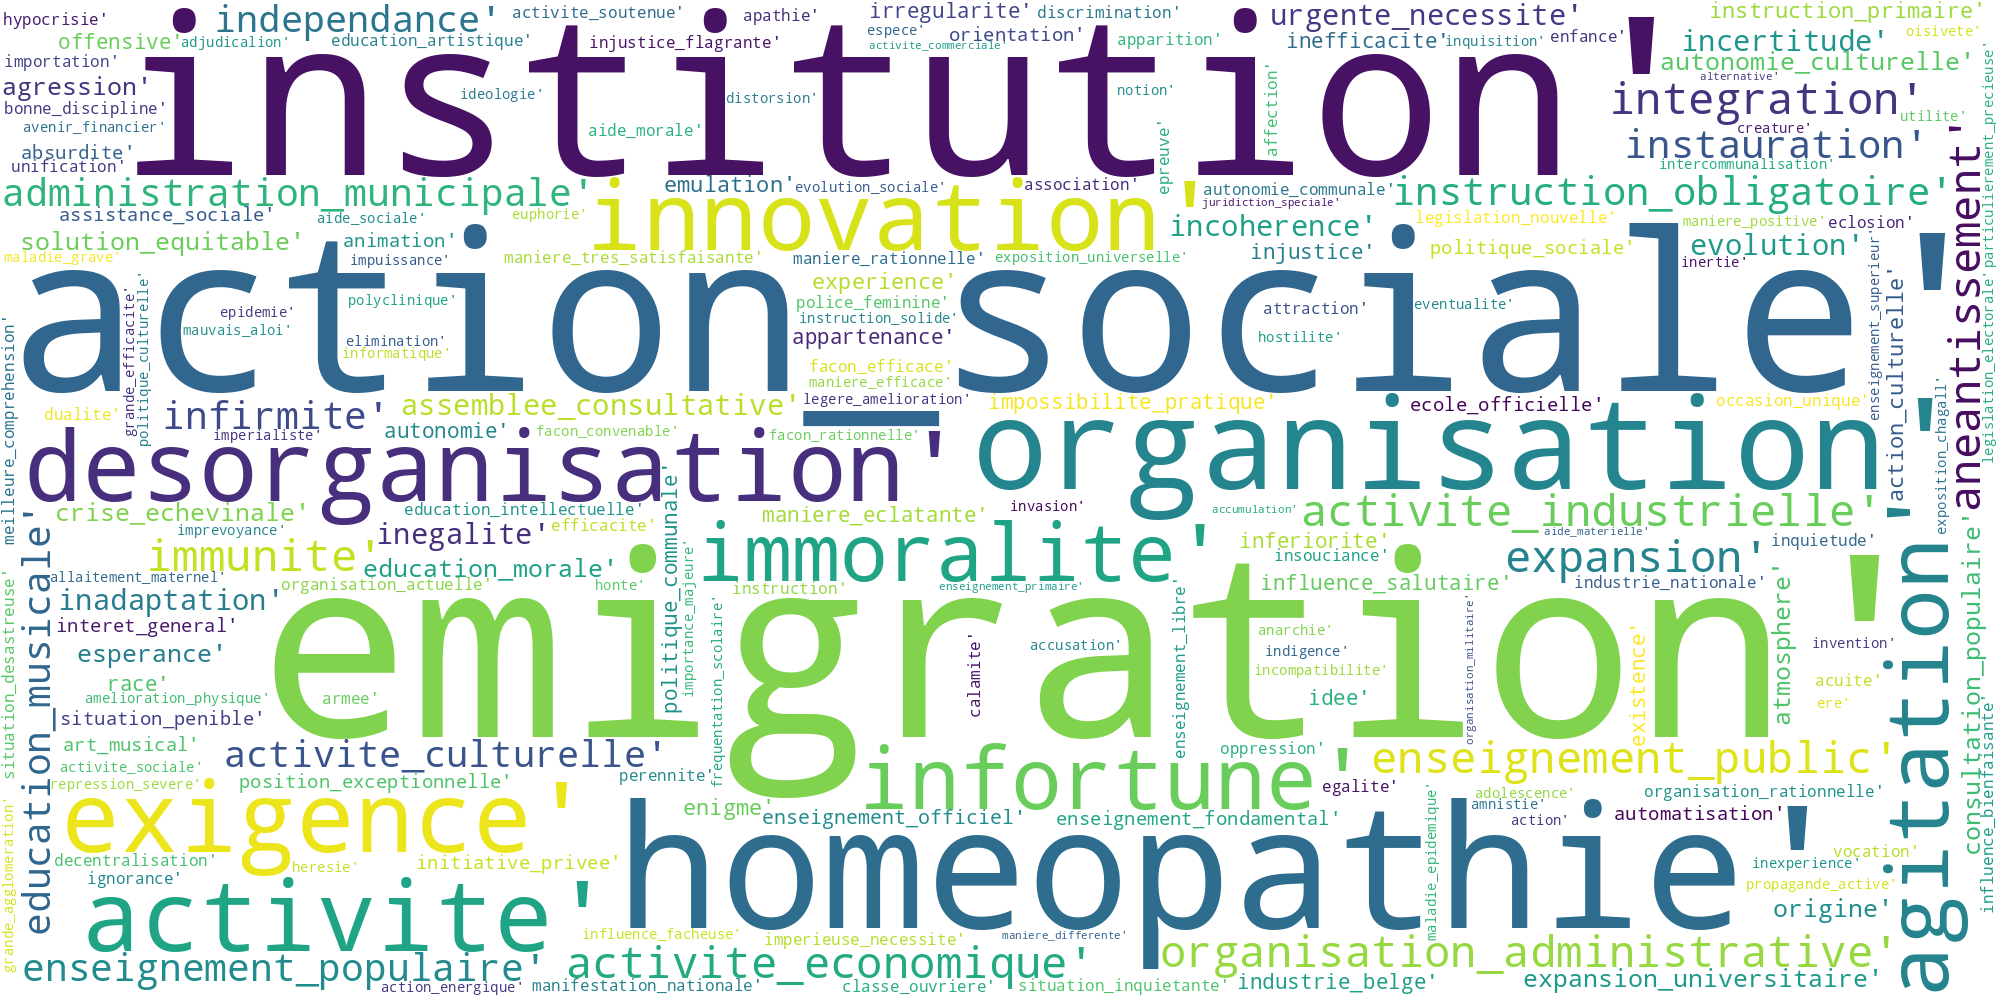

In [16]:
cloud = WordCloud(width=2000, height=1000, background_color='white', random_state=10).generate(str(most_similar_words))
cloud.to_file(os.path.join("../data/", f"{selected_word}.png"))
Image(filename=os.path.join("../data/", f"{selected_word}.png"))

In [17]:
selected_word = 'immigrant'
most_similar_words = model.wv.most_similar(selected_word, topn=200)
cloud = WordCloud(width=2000, height=1000, background_color='white', random_state=10).generate(str(most_similar_words))
cloud.to_file(os.path.join("../data/", f"{selected_word}.png"))
Image(filename=os.path.join("../data/", f"{selected_word}.png"))

KeyError: "Key 'immigrant' not present"

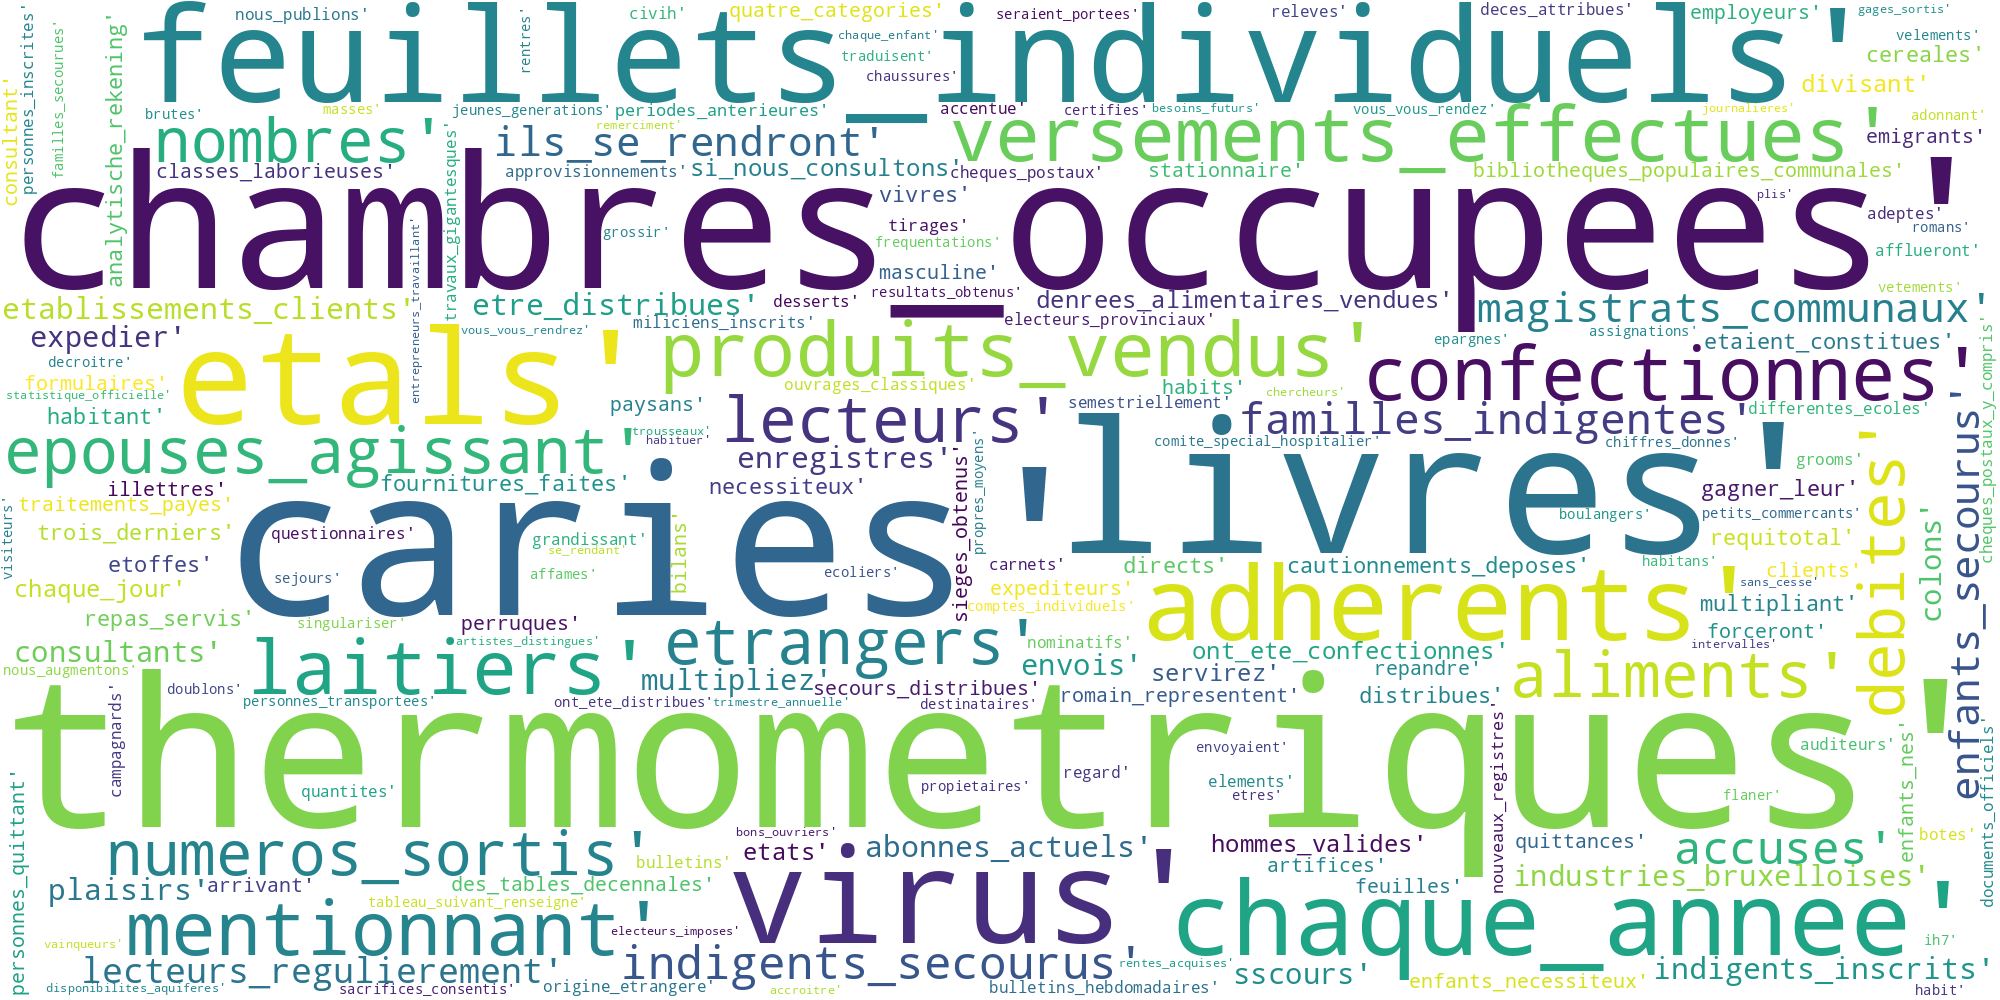

In [18]:
selected_word = 'immigrants'
most_similar_words = model.wv.most_similar(selected_word, topn=200)
cloud = WordCloud(width=2000, height=1000, background_color='white', random_state=10).generate(str(most_similar_words))
cloud.to_file(os.path.join("../data/", f"{selected_word}.png"))
Image(filename=os.path.join("../data/", f"{selected_word}.png"))

In [22]:
selected_word = 'immigre'
most_similar_words = model.wv.most_similar(selected_word, topn=200)
cloud = WordCloud(width=2000, height=1000, background_color='white', random_state=10).generate(str(most_similar_words))
cloud.to_file(os.path.join("../data/", f"{selected_word}.png"))
Image(filename=os.path.join("../data/", f"{selected_word}.png"))

KeyError: "Key 'immigre' not present"

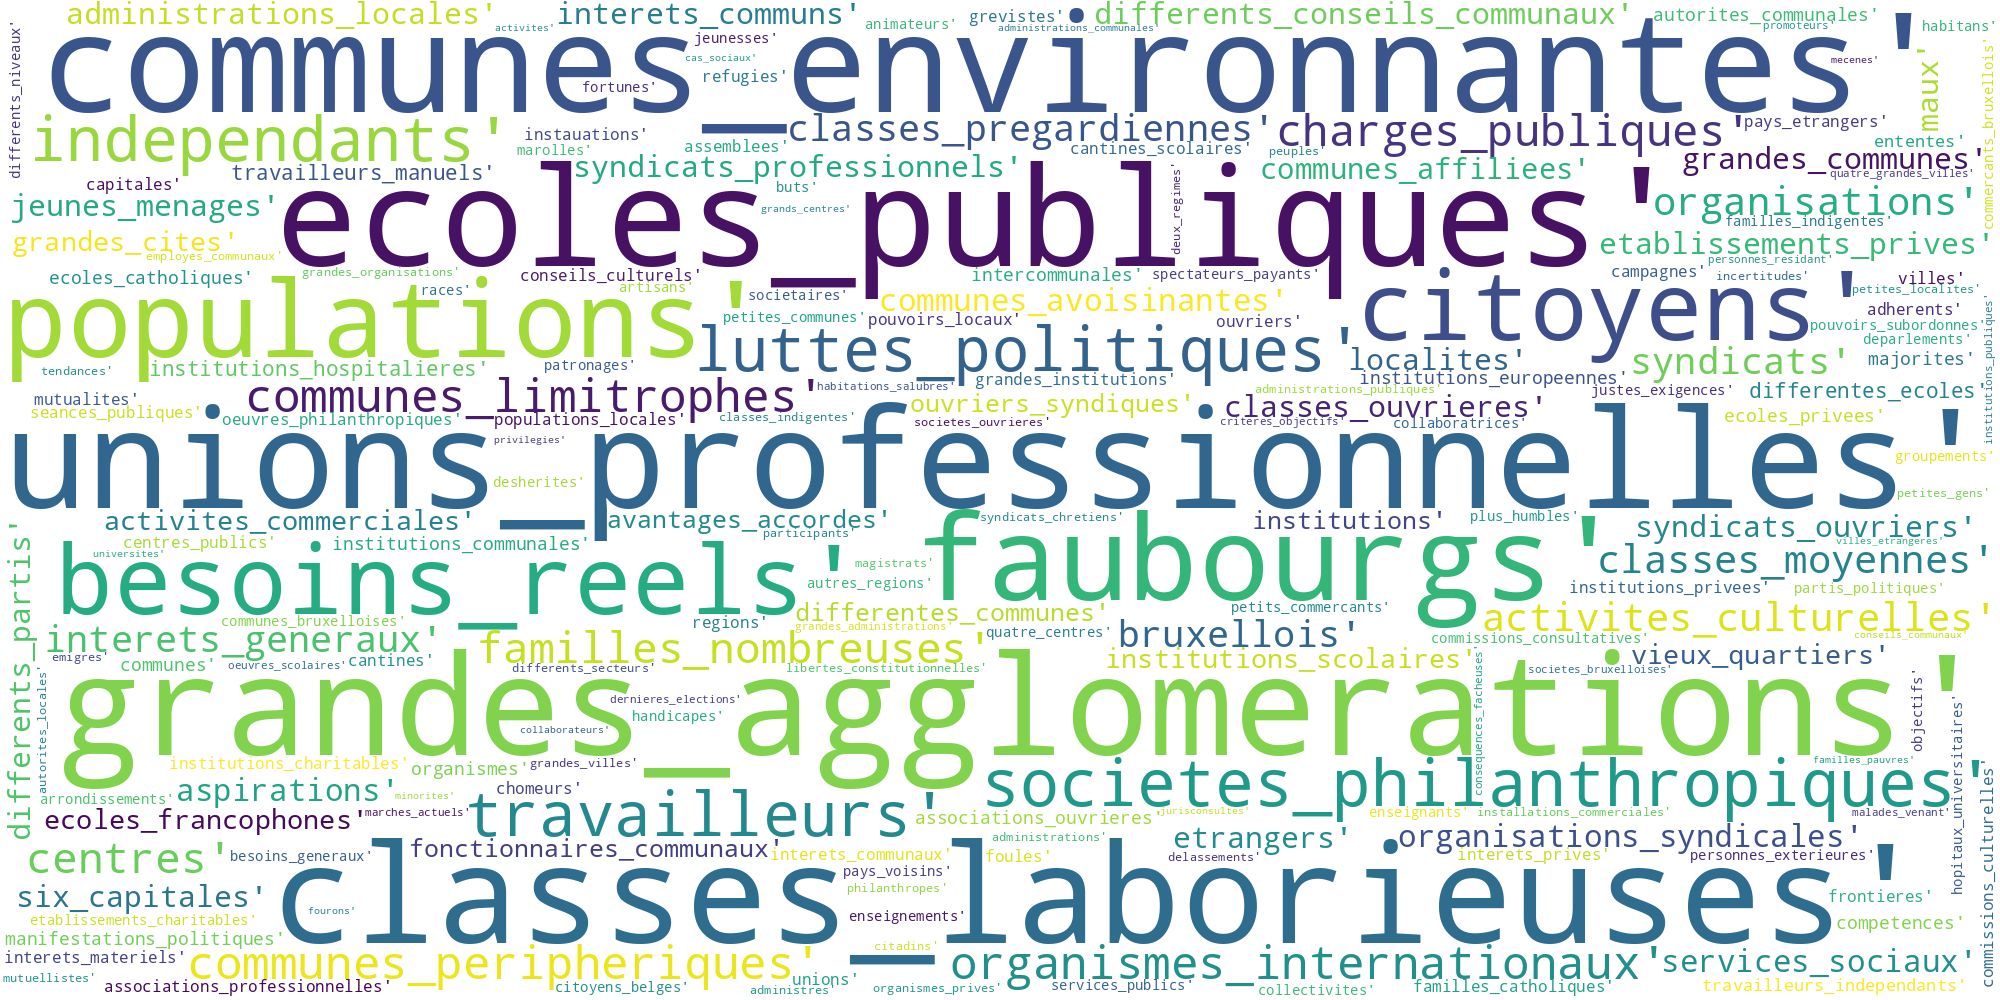

In [23]:
selected_word = 'immigres'
most_similar_words = model.wv.most_similar(selected_word, topn=200)
cloud = WordCloud(width=2000, height=1000, background_color='white', random_state=10).generate(str(most_similar_words))
cloud.to_file(os.path.join("../data/", f"{selected_word}.png"))
Image(filename=os.path.join("../data/", f"{selected_word}.png"))

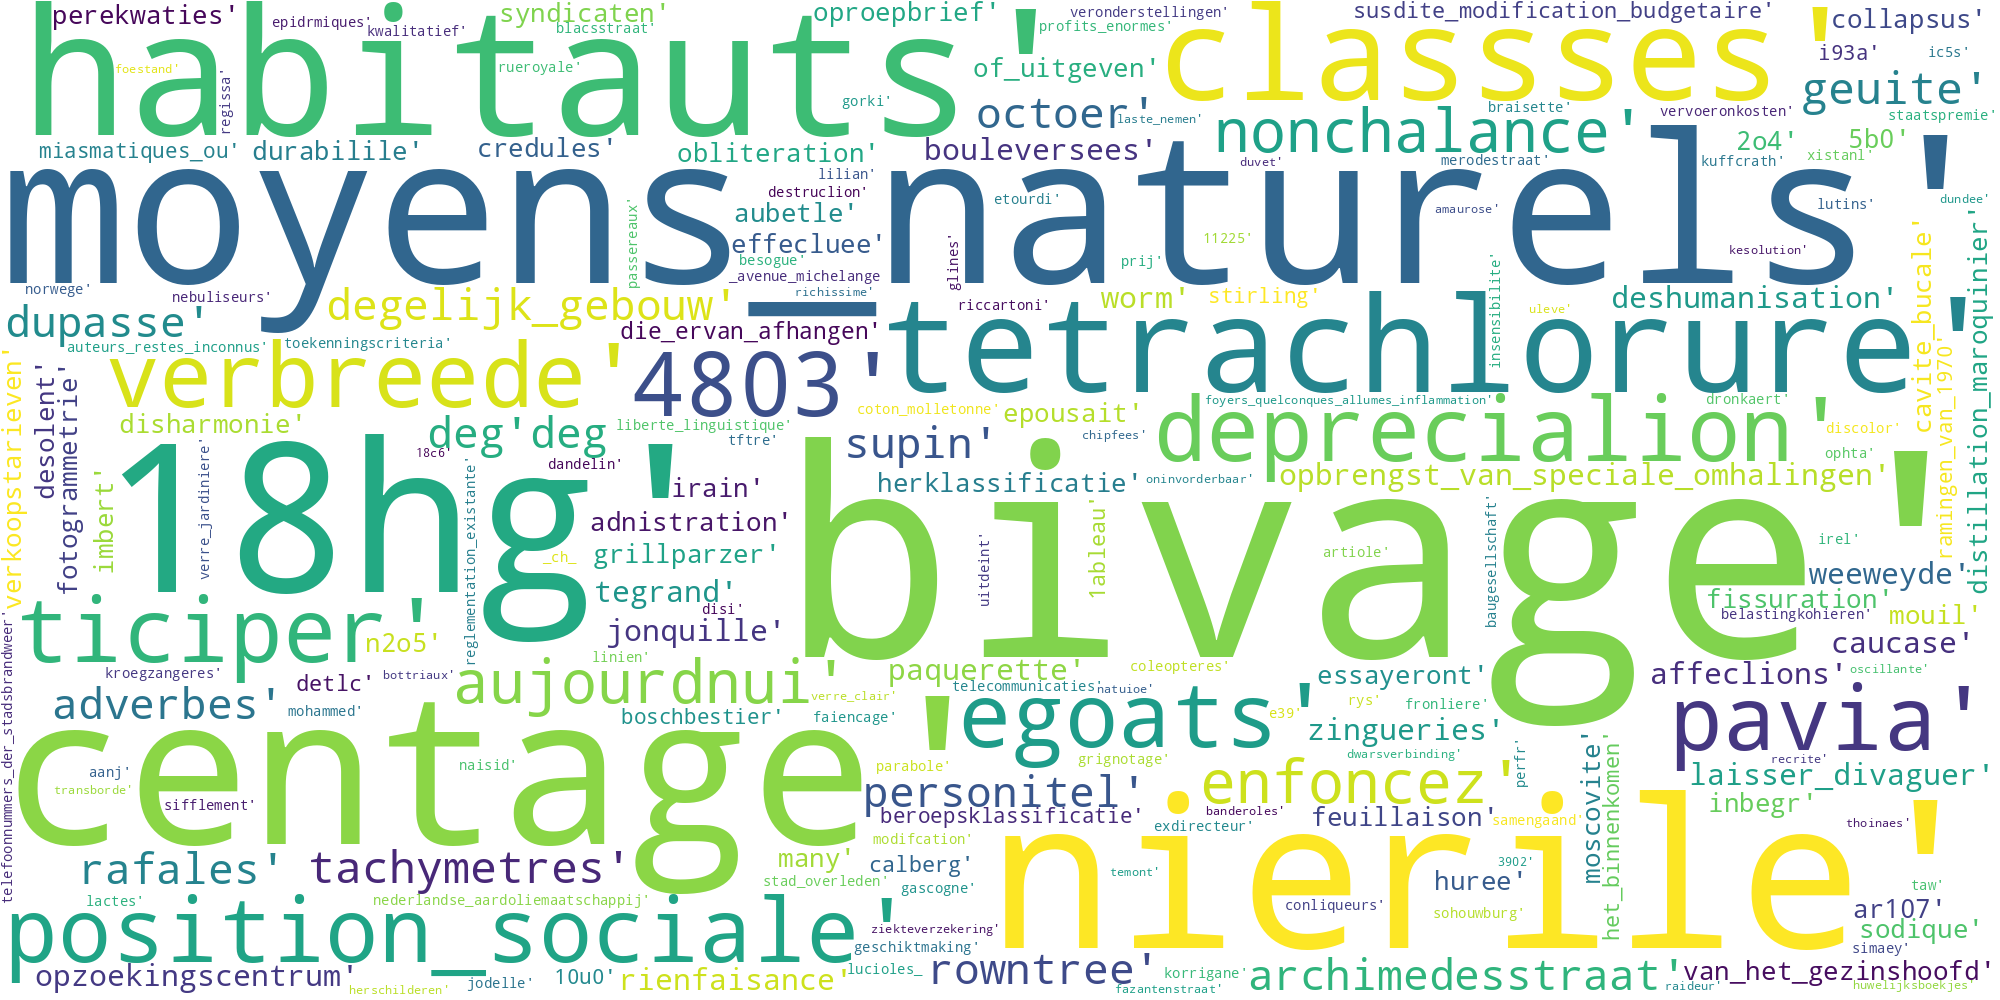

In [24]:
selected_word = 'migration'
most_similar_words = model.wv.most_similar(selected_word, topn=200)
cloud = WordCloud(width=2000, height=1000, background_color='white', random_state=10).generate(str(most_similar_words))
cloud.to_file(os.path.join("../data/", f"{selected_word}.png"))
Image(filename=os.path.join("../data/", f"{selected_word}.png"))

In [25]:
selected_word = 'migrant'
most_similar_words = model.wv.most_similar(selected_word, topn=200)
cloud = WordCloud(width=2000, height=1000, background_color='white', random_state=10).generate(str(most_similar_words))
cloud.to_file(os.path.join("../data/", f"{selected_word}.png"))
Image(filename=os.path.join("../data/", f"{selected_word}.png"))

KeyError: "Key 'migrant' not present"

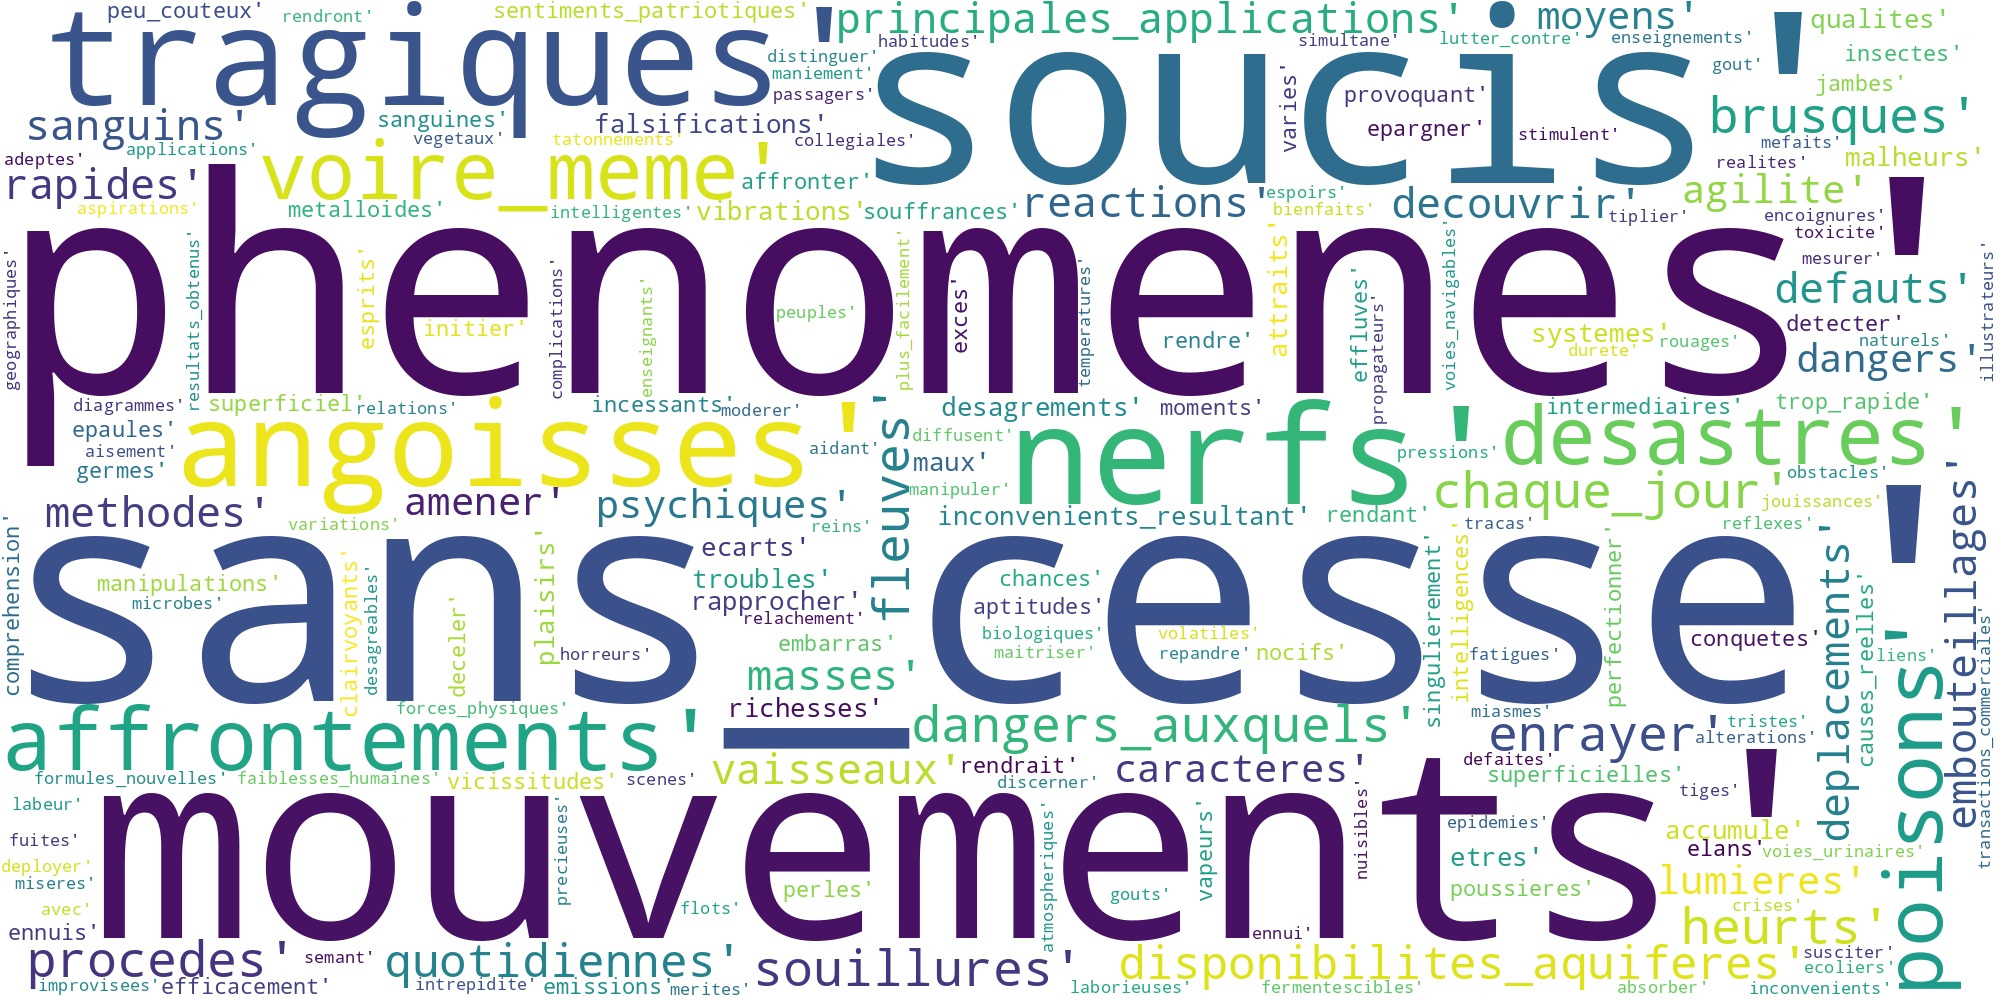

In [26]:
selected_word = 'migrants'
most_similar_words = model.wv.most_similar(selected_word, topn=200)
cloud = WordCloud(width=2000, height=1000, background_color='white', random_state=10).generate(str(most_similar_words))
cloud.to_file(os.path.join("../data/", f"{selected_word}.png"))
Image(filename=os.path.join("../data/", f"{selected_word}.png"))

## Analyse diachronique

#### Sélectionner les bulletins de la Ville de Bruxelles

In [103]:
infile_path = "../data/txt/"
files = sorted(os.listdir(infile_path))
bxl_corpus = [f for f in files if f.startswith("Bxl_")]
print(f" Mon corpus contient bien les {len(bxl_corpus)} fichiers de la Ville de Bruxelles")

 Mon corpus contient bien les 2677 fichiers de la Ville de Bruxelles


In [28]:
outfile_path = "../data/repl/"
if not os.path.exists(outfile_path):
    os.mkdir(outfile_path)

#### Fonction intermédiaire pour remettre le contenu de chaque fichier sur une ligne

In [31]:
for file in bxl_corpus:
    with open(os.path.join(outfile_path, file), 'w', encoding="utf-8") as output:
        with open(os.path.join(infile_path, file), encoding="utf-8", errors="backslashreplace") as f:
            for line in f.readlines():
                newline = line.replace("\r", "")
                newline = newline.replace("\n", "") 
                newline = re.sub(" +", " ", newline)
                if not newline.endswith(" "):
                    newline += " "
                output.write(newline)

#### Créer le dossier de destination des fichiers segmentés en phrases

In [32]:
infile_path = "../data/repl/"
outfile_path = "../data/sents/"
if not os.path.exists(outfile_path):
    os.mkdir(outfile_path)

#### Fonction de segmentation du texte en phrases

In [35]:
for file in bxl_corpus:
    with open(os.path.join(outfile_path, file), 'w', encoding="utf-8") as output:
        with open(os.path.join(infile_path, file), encoding="utf-8", errors="backslashreplace") as f:
            for line in f:
                sentences = sent_tokenize(line)
                for sent in sentences:
                    output.write(sent + "\n")

#### Direction vers le dossier avec mes nouveaux fichiers

In [104]:
infile_path = "../data/sents/"
files = sorted(os.listdir(infile_path))
bxl_files = [f for f in files]
print(f" Mon corpus contient bien mes {len(bxl_files)} fichiers.")

 Mon corpus contient bien mes 2677 fichiers.


#### Fonction d'analyse des sentiments

In [105]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

def get_sentiment(input_text):
    blob = tb(input_text)
    polarity, subjectivity = blob.sentiment
    polarity_perc = f"{100*abs(polarity):.0f}"
    subjectivity_perc = f"{100*subjectivity:.0f}"
    if polarity > 0:
        polarity_str = f"{polarity_perc}% positive"
    elif polarity < 0:
        polarity_str = f"{polarity_perc}% negative"
    else:
        polarity_str = "neutral"
    if subjectivity > 0:
        subjectivity_str = f"{subjectivity_perc}% subjective"
    else:
        subjectivity_str = "perfectly objective"
    print(f"This text is {polarity_str} and {subjectivity_str}.")

#### Query pour récupérer le noms des pays et de leurs habitants

In [140]:
endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql" 
sparql = SPARQLWrapper(endpoint) 

statement = """
SELECT DISTINCT ?pays ?paysLabel ?gentileLabel WHERE {
    ?pays wdt:P31 wd:Q3624078 .
    ?pays wdt:P1549 ?gentileLabel .
    SERVICE wikibase:label { bd:serviceParam wikibase:language "fr" . }
}
ORDER BY ?paysLabel
"""

sparql.setQuery(statement) 
sparql.setReturnFormat(JSON) 
results = sparql.query().convert()

In [141]:
rows = results['results']['bindings']

pays = []
nationalités = []

for row in rows:
    pays.append(row["paysLabel"]["value"])
    if row["gentileLabel"]["xml:lang"] == "fr":
        nationalités.append(row["gentileLabel"]["value"])

print(f"La lite des {len(set(pays))} pays reprend {len(set(nationalités))} graphèmes différents pour les nationalités.\n")

La lite des 199 pays reprend 454 graphèmes différents pour les nationalités.



In [143]:
pays_nationalités = pays + nationalités
print(sorted(set(pays_nationalités)))

['Afghan', 'Afghane', 'Afghanistan', 'Afrique du Sud', 'Albanais', 'Albanaise', 'Albanie', 'Algérie', 'Algérien', 'Algérienne', 'Allemagne', 'Allemand', 'Allemande', 'Américain', 'Américaine', 'Andorran', 'Andorrane', 'Andorre', 'Anglais', 'Anglaise', 'Angola', 'Angolais', 'Angolaise', 'Antigua-et-Barbuda', 'Antiguayen', 'Antiguayenne', 'Arabie saoudite', 'Argentin', 'Argentine', 'Arménie', 'Arménien', 'Arménienne', 'Arméniens', 'Australie', 'Australien', 'Australienne', 'Autriche', 'Autrichien', 'Autrichienne', 'Azerbaïdjan', 'Azerbaïdjanais', 'Azerbaïdjanaise', 'Bahamas', 'Bahaméen', 'Bahaméenne', 'Bahreïn', 'Bahreïnien', 'Bahreïnienne', 'Bangladais', 'Bangladaise', 'Bangladesh', 'Barbade', 'Barbadien', 'Barbadienne', 'Belge', 'Belgique', 'Belize', 'Bhoutan', 'Bhoutanais', 'Bhoutanaise', 'Birman', 'Birmane', 'Birmanie', 'Bissaoguinéen', 'Bissaoguinéenne', 'Biélorusse', 'Biélorussie', 'Bolivie', 'Bolivien', 'Bolivienne', 'Bosnie-Herzégovine', 'Bosnien', 'Bosnienne', 'Botswana', 'Botsw

In [144]:
endpoint = "https://query.wikidata.org/bigdata/namespace/wdq/sparql" 
sparql = SPARQLWrapper(endpoint) 

statement = """
SELECT DISTINCT ?region ?regionLabel ?gentileLabel WHERE {
    ?region wdt:P31 wd:Q15634554 .
    ?region wdt:P1549 ?gentileLabel .
    SERVICE wikibase:label { bd:serviceParam wikibase:language "fr" . }
}
ORDER BY ?regionLabel
"""

sparql.setQuery(statement) 
sparql.setReturnFormat(JSON) 
results = sparql.query().convert()

In [145]:
rows = results['results']['bindings']

régions = []
régionalités = []

for row in rows:
    régions.append(row["regionLabel"]["value"])
    if row["gentileLabel"]["xml:lang"] == "fr":
        régionalités.append(row["gentileLabel"]["value"])

print(f"La lite des {len(set(régions))} pays reprend {len(set(régionalités))} graphèmes différents pour les nationalités.\n")

La lite des 12 pays reprend 21 graphèmes différents pour les nationalités.



In [146]:
pays_nationalités += régions 
pays_nationalités += régionalités

#### Exclusion des mots qui après la segmentation en mots ne relèvent plus beaucoup de sens ++ Belgique et belge

In [148]:
suppr = ["Belgique", "Belge", "République", "État", "du", "de", "Republique", "populaire", "des", "unis", "États", "Nord", "Sud", "Cité", "democratique", "libre", "démocratique"]

words_reg = []
for word in pays_nationalités:
    words = word.split(" ")
    for w in words:
        if w not in suppr:
            words_reg.append(w.lower())
            words_reg = list(set(words_reg))

print(sorted(words_reg))

['abkhaze', 'afghan', 'afghane', 'afghanistan', 'afrique', 'albanais', 'albanaise', 'albanie', 'algérie', 'algérien', 'algérienne', 'allemagne', 'allemand', 'allemande', 'américain', 'américaine', 'andorran', 'andorrane', 'andorranes', 'andorrans', 'andorre', 'anglais', 'anglaise', 'angola', 'angolais', 'angolaise', 'antigua-et-barbuda', 'antiguayen', 'antiguayenne', 'arabe', 'arabes', 'arabie', 'argentin', 'argentine', 'arménie', 'arménien', 'arménienne', 'arméniens', 'artsakh', 'artsakhiote', 'australie', 'australien', 'australienne', 'autriche', 'autrichien', 'autrichienne', 'azerbaïdjan', 'azerbaïdjanais', 'azerbaïdjanaise', 'bahamas', 'bahaméen', 'bahaméenne', 'bahreïn', 'bahreïnien', 'bahreïnienne', 'bangladais', 'bangladaise', 'bangladesh', 'barbade', 'barbadien', 'barbadienne', 'belize', 'bhoutan', 'bhoutanais', 'bhoutanaise', 'birman', 'birmane', 'birmanie', 'bissaoguinéen', 'bissaoguinéenne', 'biélorusse', 'biélorussie', 'bolivie', 'bolivien', 'bolivienne', 'bosnie-herzégovin

#### Ajout de termes à ma liste

In [149]:
words_reg.append("juif")
words_reg.append("juive")
words_reg.append("isra")
words_reg.append("musulman")
words_reg.append("palestine")

### Recherche de termes à l'intérieur du corpus

In [63]:
list_of_words = [r"\bles étrangers", r"\bles etrangers", r"\bdes étrangers", r"\bdes etrangers"]

In [49]:
list_of_words = ["immigration", "immigre", "immigrant", r"\bmigration", r"\bmigrant"]

In [47]:
list_of_words = ["assimilation", r"\bintegration", r"\bintégration"]

In [114]:
list_of_words = ["immigration", "immigre", "immigrant", r"\bmigration", r"\bmigrant"]

count_years = defaultdict(int)
count_decades = defaultdict(int)
covered_years_imm = set()
files_th_imm = []
crp_imm = defaultdict()
locations = defaultdict(int)
miscellaneous = defaultdict(int)

for file in bxl_files:
    
    # traitement du nom du fichier
    file_name = file
    elems = file.split("_")
    year = elems[1]
    decade = year[:3] + "0s"
    
    # stockage temporaire des lignes du fichier à traiter
    infile = open(os.path.join(infile_path, file), "r", encoding="utf-8")
    lines = infile.readlines()
    infile.close()
    inlines = {}
    i = 0
    for line in lines:
        msg = " ".join(line.split("\t")[0:]).strip()
        inlines[i] = {"msg": msg}
        i += 1
    
    # recherche des termes et constitution du corpus de phrases
    out = []
    regex = re.compile("|".join(list_of_words), re.IGNORECASE)
    for i in inlines:
        linehits = regex.findall(inlines[i]["msg"])
        if linehits:
            target = inlines[i]["msg"]
            tmp = target
            if i > 0:
                avant = inlines[i-1]["msg"]
                tmp = (avant + " " + target)
            if i+1 < len(inlines):
                après = inlines[i+1]["msg"]
                tmp += (" " + après)
            if i+2 < len(inlines)-1:
                apr = inlines[i+2]["msg"]
                tmp += (" " + apr)
            out.append(tmp)
            
    # exploitation des données et enrichissements
    if len(out) > 0:
        covered_years_imm.add(year)
        count_decades[decade] += len(out)
        count_years[year] += len(out)
        files_th_imm.append(file_name)
        
        print(f'\n\033[1m\033[4mIl y a {len(out)} occurence(s) dans le fichier "{file_name}" :\033[0;0m')
        
        for extract in out:
            
            print(f"\n\033[96m{extract}\033[0;0m")
            
            # traitement des entités nommées
            doc = nlp(extract)
            loc = set()
            misc = set()
            for ent in doc.ents:
                if ent.label_ == "LOC" and len(ent.text) > 3:
                    loc.add(f"{ent.text} ({ent.label_})")
                    locations[ent.text] += 1
                if ent.label_ == "MISC" and len(ent.text) > 3:
                    misc.add(f"{ent.text} ({ent.label_})")
                    miscellaneous[ent.text] += 1
            if loc or misc:
                if loc:
                    print(f"Cet extrait contient les lieux suivants : {', '.join(loc)}")
                if misc:
                    print(f"Cet extrait contient les entités diverses suivants : {', '.join(misc)}")
            else:
                print(f"Cet extrait ne contient aucune entité nommée")
                
            # analyse des sentiments
            get_sentiment(extract)


Il y a 2 occurence(s) dans le fichier "Bxl_1865_Tome_II1_Part_5.txt" :

Elle appelle nécessairement à elle tout ce q u i , dans le pays, recherche le mouvement, le plaisir, les agréments. Aussi la population de Bruxelles et de la banlieue n'a-t-elle pas pris les proportions énormes que nous voyons depuis quelques années, par la simple augmentation de la population suivant son cours naturel : elle a pris cet accroissement par l'immigration. Or, cette immigration, d'où vient-elle? Pour une faible partie, de l'étranger; pour la plus grande partie, des provinces du pays.
Cet extrait contient les lieux suivants : Bruxelles (LOC)
This text is 10% positive and 24% subjective.

Aussi la population de Bruxelles et de la banlieue n'a-t-elle pas pris les proportions énormes que nous voyons depuis quelques années, par la simple augmentation de la population suivant son cours naturel : elle a pris cet accroissement par l'immigration. Or, cette immigration, d'où vient-elle? Pour une faible partie, 

In [115]:
print(f"Le nombre d'années couvertes par les thèmes de l'immigration s'élève à {len(covered_years_imm)} ans pour lequelles {len(files_th_imm)} bulletins différents ont été recensés.")

Le nombre d'années couvertes par les thèmes de l'immigration s'élève à 60 ans pour lequelles 128 bulletins différents ont été recensés.


#### Graphique des occurences par années

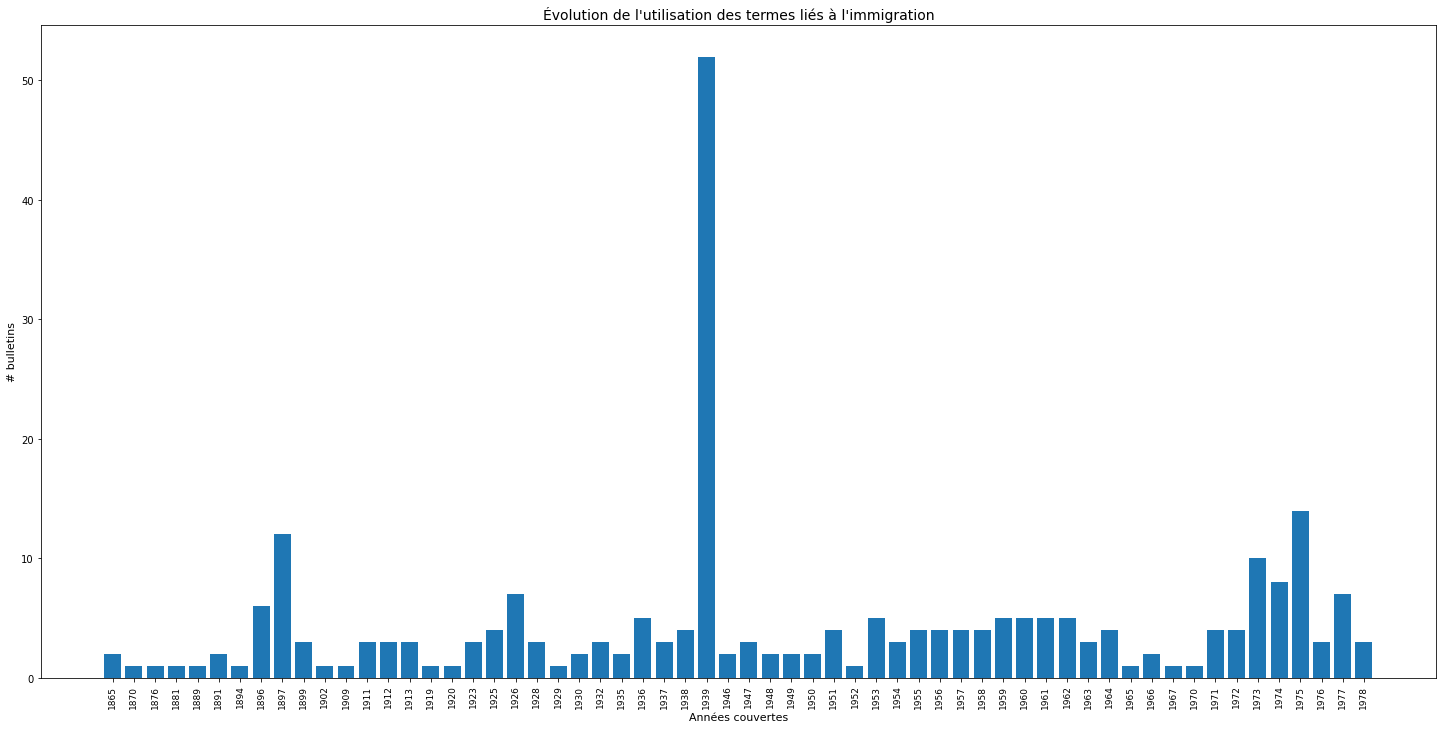

In [116]:
fig = plt.figure(1, figsize=(25, 12))
index = np.arange(len(count_years))
plt.bar(index, count_years.values())
plt.xlabel('Années couvertes', fontsize=11)
plt.ylabel('# bulletins', fontsize=11)
plt.xticks(index, count_years.keys(),fontsize=9, rotation=90)
plt.title("Évolution de l'utilisation des termes liés à l'immigration", fontsize=14)
plt.show()

In [118]:
print(f"Le nombre d'années couvertes par le thème relatif aux étrangers s'élève à {len(covered_years_etr)} ans pour lequelles {len(files_th_etr)} bulletins différents ont été recensés.")

Le nombre d'années couvertes par le thème relatif aux étrangers s'élève à 122 ans pour lequelles 706 bulletins différents ont été recensés.


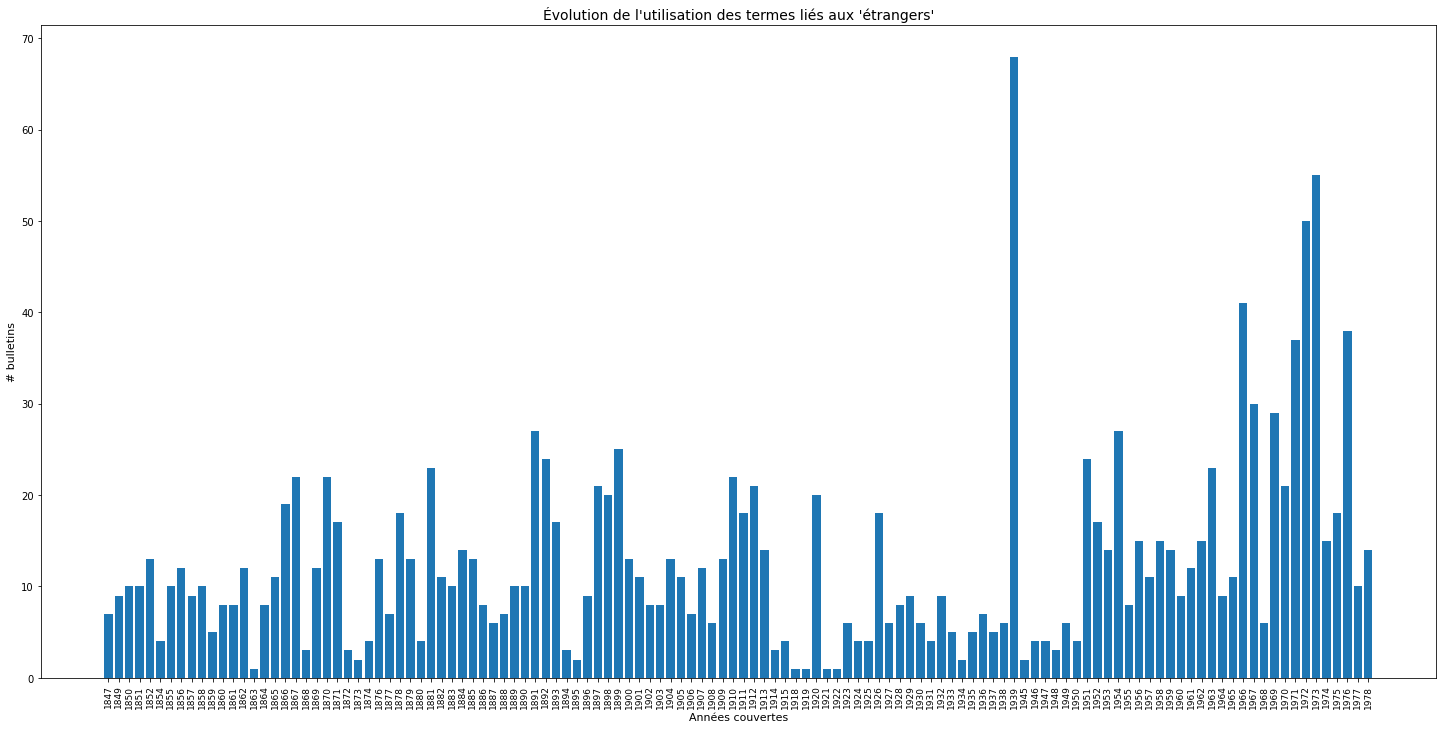

In [119]:
fig = plt.figure(1, figsize=(25, 12))
index = np.arange(len(count_years))
plt.bar(index, count_years.values())
plt.xlabel('Années couvertes', fontsize=11)
plt.ylabel('# bulletins', fontsize=11)
plt.xticks(index, count_years.keys(),fontsize=9, rotation=90)
plt.title("Évolution de l'utilisation des termes liés aux 'étrangers'", fontsize=14)
plt.show()

In [150]:
list_of_words = ["immigration", "immigre", "immigrant", r"\bmigration", r"\bmigrant", r"\bles étrangers", r"\bles etrangers", r"\bdes étrangers", r"\bdes etrangers"]
crp = defaultdict()

for file in bxl_files:
    
    # traitement du nom du fichier
    elems = file.split("_")
    year = elems[1]
    
    # stockage temporaire des lignes du fichier à traiter
    infile = open(os.path.join(infile_path, file), "r", encoding="utf-8")
    lines = infile.readlines()
    infile.close()
    inlines = {}
    i = 0
    for line in lines:
        msg = " ".join(line.split("\t")[0:]).strip()
        inlines[i] = {"msg": msg}
        i += 1
    
    # recherche des termes et constitution du corpus de phrases
    out = []
    regex = re.compile("|".join(list_of_words), re.IGNORECASE)
    for i in inlines:
        linehits = regex.findall(inlines[i]["msg"])
        if linehits:
            target = inlines[i]["msg"]
            tmp = target
            if i > 0:
                avant = inlines[i-1]["msg"]
                tmp = (avant + " " + target)
            if i+1 < len(inlines):
                après = inlines[i+1]["msg"]
                tmp += (" " + après)
            if i+2 < len(inlines)-1:
                apr = inlines[i+2]["msg"]
                tmp += (" " + apr)
            out.append(tmp)
            
    # exploitation des données
    crp[year] = list()
    if len(out) > 0:
        for extract in out:
            regx = re.compile("|".join(words_reg), re.IGNORECASE)
            results = regx.findall(extract)
            if results:
                for word in results:
                    crp[year].append(word)

In [151]:
print(crp)

defaultdict(None, {'1847': [], '1848': [], '1849': [], '1850': [], '1851': [], '1852': [], '1854': [], '1855': [], '1856': [], '1857': [], '1858': [], '1859': [], '1860': [], '1861': [], '1862': [], '1863': [], '1864': [], '1865': [], '1866': [], '1867': [], '1868': [], '1869': [], '1870': [], '1871': [], '1872': [], '1873': [], '1874': [], '1876': [], '1877': [], '1878': [], '1879': ['inde', 'inde', 'Inde'], '1880': [], '1881': ['Inde'], '1882': [], '1883': [], '1884': [], '1885': [], '1886': [], '1887': [], '1888': [], '1889': [], '1890': [], '1891': [], '1892': [], '1893': [], '1894': [], '1895': ['mali'], '1896': [], '1897': ['allemand', 'anglais', 'allemande', 'anglaise'], '1898': [], '1899': [], '1900': [], '1901': [], '1902': [], '1903': [], '1904': [], '1905': [], '1906': [], '1907': [], '1908': [], '1909': [], '1910': [], '1911': [], '1912': [], '1913': [], '1914': [], '1915': [], '1918': [], '1919': [], '1920': [], '1921': [], '1922': [], '1923': [], '1924': [], '1925': [], '

J'étais parvenue à des résultats plus probants, mais j'ai trop chipoté dans le code... je ne parviens plus à sortir une liste plus complète :-/